## Imports

In [1]:
import torch
import kornia
import cv2
import numpy as np
import imutils
from glob import glob
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from time import time

## Colormaps

In [2]:
def create_cityscapes_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[:19, :] = np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])
    return ListedColormap(colormap / 255., N=256)



In [3]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / 1, 'black'),
                                                    (1 / 1, [0.86,0.86,0.86])])
colormap = create_cityscapes_colormap()
colormap_gray = create_cityscapes_colormap()
torch.set_grad_enabled(False)

## Functions

In [4]:
class Stitcher:
    def __init__(self):
        self.cachedHlc = None
        self.cachedHrc = None
        
    def stitch(self,Masks,result_width,M_left_center,M_center_right):
        (Maskleft_image, Maskcenter_image, Maskright_image) = Masks
        
        self.cachedHlc = M_left_center
        self.cachedHrc = M_center_right
        
        #result_width = 3200
        T = np.array([[1.0, 0.0, (result_width/2)-(Masks[0].shape[3]/2)],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]]).astype(dtype=np.float32)
        

        transformations = [self.cachedHlc, np.identity(3, dtype=np.float32), self.cachedHrc]
        #result = np.zeros((Masks[0].shape[0],Masks[0].shape[1],result_width)).astype(np.float32)
        #weights = np.zeros_like(result)
        
        result = 0
        weights = 1e-6
        
        for i in range(len(Masks)):
            warp = kornia.warp_perspective(Masks[i], 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[2],result_width))
            weight = kornia.warp_perspective(torch.tensor(np.ones_like(Masks[i])), 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[2],result_width))
            
            
            #result =  kornia.color.add_weighted(torch.tensor(result),1.0,warp,1.0,0.0)
            #weights = kornia.color.add_weighted(torch.tensor(weights),1.0,weight,1.0,0.0)
            result = warp + result
            weights = weights + weight

        return result / weights
        #return np.uint8(kornia.tensor_to_image(result) / kornia.tensor_to_image(weights))
    
    
    def stitchNormal(self,Masks,result_width,M_left_center,M_center_right):
        (Maskleft_image, Maskcenter_image, Maskright_image) = Masks
        
        self.cachedHlc = M_left_center
        self.cachedHrc = M_center_right
        
        #result_width = 3200
        T = np.array([[1.0, 0.0, (result_width/2)-(Masks[0].shape[1]/2)],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]]).astype(dtype=np.float32)
        

        transformations = [self.cachedHlc, np.identity(3, dtype=np.float32), self.cachedHrc]
        #result = np.zeros((Masks[0].shape[0],Masks[0].shape[1],result_width)).astype(np.float32)
        #weights = np.zeros_like(result)
        
        result = 0
        weights = 1e-6
        
        for i in range(len(Masks)):
            warp = kornia.warp_perspective(Masks[i], 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[0],result_width))
            weight = kornia.warp_perspective(torch.tensor(np.ones_like(Masks[i])), 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[0],result_width))
            
            
            #result =  kornia.color.add_weighted(torch.tensor(result),1.0,warp,1.0,0.0)
            #weights = kornia.color.add_weighted(torch.tensor(weights),1.0,weight,1.0,0.0)
            result = warp + result
            weights = weights + weight

        return result / weights
        #return np.uint8(kornia.tensor_to_image(result) / kornia.tensor_to_image(weights))

    
    
    
    
    def transformationsCalculator(self,images,ratio=0.8, reprojThresh=4.0):
        (image_left, image_center, image_right) = images
        
        (kpsLeft, featuresLeft) = self.detectAndDescribe(image_left)
        (kpsCenter, featuresCenter) = self.detectAndDescribe(image_center)
        (kpsRight, featuresRight) = self.detectAndDescribe(image_right)

        if kpsLeft is None or kpsCenter is None or kpsRight is None:
            print("It was not possible to extract the keypoints")
            return None
        print("Chegou ate aqui")
        M_left_center = self.matchKeypoints(kpsLeft, kpsCenter,featuresLeft, featuresCenter, ratio, reprojThresh)
        M_right_center = self.matchKeypoints(kpsRight, kpsCenter,featuresRight, featuresCenter, ratio, reprojThresh)

        if M_left_center is None or M_right_center is None:
            print("Uma das matrizes nao foi calculada")
            return None
        print("supostamente calculou tudo")
        return (M_left_center[1],M_right_center[1])
    
    def detectAndDescribe(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detector = cv2.ORB_create(nfeatures=1000)
        kps = detector.detect(gray, None)
        (kps,features) = detector.compute(gray, kps)
        kps = np.float32([kp.pt for kp in kps])
        return (kps,features) 
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        if len(matches) > 15:
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)
            return (matches, H, status)
        return None


In [5]:
def polygonGenerator(image,hullMode):
    import scipy
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely import geometry
    from descartes import PolygonPatch
    
    
    #select the coordinates where the edges where found and define [0,0] as point to close the loop
    if hullMode ==False:
        #Get coordinates where road was detected
        points = np.column_stack(np.where((image)==1))
    else:
        #Convert the image to grayscale & find edges
        img = np.uint8(np.float32(image))
        edges = cv2.Canny(img,3,3)
        coords = np.column_stack(np.where(edges==255))
        points = np.zeros((len(coords)+1, 2))
        points[:len(coords),:]= coords
        points[len(coords),0]= 736

    return points

def polygonStitcher(Points,img_height,img_width,M_left_center,M_center_right,result_width,hullMode,Lines=False):
    import cv2
    import numpy as np
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    from shapely import geometry
    from descartes import PolygonPatch

    (PointsE, PointsM, PointsD) = Points
    
    pointsE[:,0]= img_height-pointsE[:,0]
    pointsM[:,0]= img_height-pointsM[:,0]
    pointsD[:,0]= img_height-pointsD[:,0]
    
    
    pointsD[:,[0, 1]] = pointsD[:,[1, 0]]
    pointsM[:,[0, 1]] = pointsM[:,[1, 0]]
    pointsE[:,[0, 1]] = pointsE[:,[1, 0]]
    d = np.array([pointsD.astype('float32')])
    m = np.array([pointsM.astype('float32')])
    e = np.array([pointsE.astype('float32')])

    T = np.array([[1.0, 0.0, (result_width/2)-(img_width/2)],
                          [0.0, 1.0, 0.0],
                          [0.0, 0.0, 1.0]]).astype(dtype=np.float32)


    pointsOutD = cv2.perspectiveTransform(d, np.dot(T,M_center_right))
    pointsOutM = cv2.perspectiveTransform(m, T)
    pointsOutE = cv2.perspectiveTransform(e, np.dot(T,M_left_center))
    
    pointsOutE = pointsOutE[-1,:,:]
    pointsOutM = pointsOutM[-1,:,:]
    pointsOutD = pointsOutD[-1,:,:]
    
    imagemPoints = np.zeros([img_height,result_width])
    
    pointList=np.concatenate((pointsOutE,pointsOutM,pointsOutD))
    
    if hullMode ==True:
        pointListPoly= []
        hull= ConvexHull(pointList)
        

        if Lines == True:
            pointsTeste = np.zeros((len(pointList[hull.vertices[:],0])+1, 2))
            pointsTeste[:len(pointList[hull.vertices[:],0]),:]= pointList[hull.vertices[:],:]
            pointsTeste[len(pointList[hull.vertices[:],0]),:]=  pointList[hull.vertices[0],:]
            fig, ay = plt.subplots(figsize=(15, 15))
            #ay.set_title('Road Limits')
            ay.imshow(imagemPoints,cmap=cmap)
            ay.set_axis_off()  
            ay.plot(pointsTeste[:,0], pointsTeste[:,1], linestyle='solid', color='gainsboro', lw=1)
            xrange = [0, result_width]
            yrange = [0, img_height]
            ay.set_xlim(*xrange)
            ay.set_ylim(*yrange)
            ay.set_aspect(1)
            plt.savefig('Images_Presentation/PanoLines.jpg', dpi=500)
            print("Polygon with Lines")
        else:
            for i in range(len(hull.vertices[:])):
                p = geometry.Point(pointList[hull.vertices[i],1],pointList[hull.vertices[i],0])
                pointListPoly.append(p)

            poly = geometry.Polygon([[p.y, p.x] for p in pointListPoly])
            x,y = poly.exterior.xy
            ring_patch = PolygonPatch(poly)
            ring_patch.set_color([0.92,0.92,0.92])
            fig, az = plt.subplots(figsize=(15, 15))
            az.imshow(imagemPoints,cmap=cmap)
            az.add_patch(ring_patch)
            #az.set_title('Road Polygon')
            xrange = [0, result_width]
            yrange = [0, img_height]
            az.set_xlim(*xrange)
            az.set_ylim(*yrange)
            az.set_aspect(1)
            az.set_axis_off()
            plt.savefig('Images_Presentation/PanoPolygon.jpg', dpi=500)
            print("Polygon ")
        
    else:
        
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(imagemPoints,cmap='gray')
        ax.scatter(pointList[:,0], pointList[:,1], marker='.', color=[0.92,0.92,0.92],lw=1)
        #ax.set_title('Road Mask')
        xrange = [0, result_width]
        yrange = [0, img_height]
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_aspect(1)
        ax.set_axis_off()
        print("Road Points")
        plt.savefig('Images_Presentation/PanoMask.jpg', dpi=500)
     
    return pointList


# Segmentation process

## Import model

In [6]:
device = torch.device('cuda:0')
model = torch.jit.load('contextnet14_bdd100k_miou0.503.pth')
#model = model.cpu()
model = model.to(device).eval()

## Individual images segmentation

(1, 736, 1280, 3)


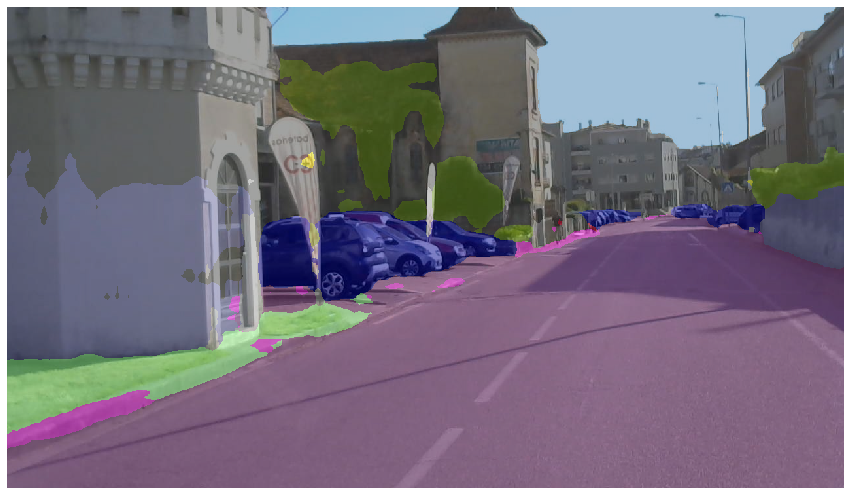

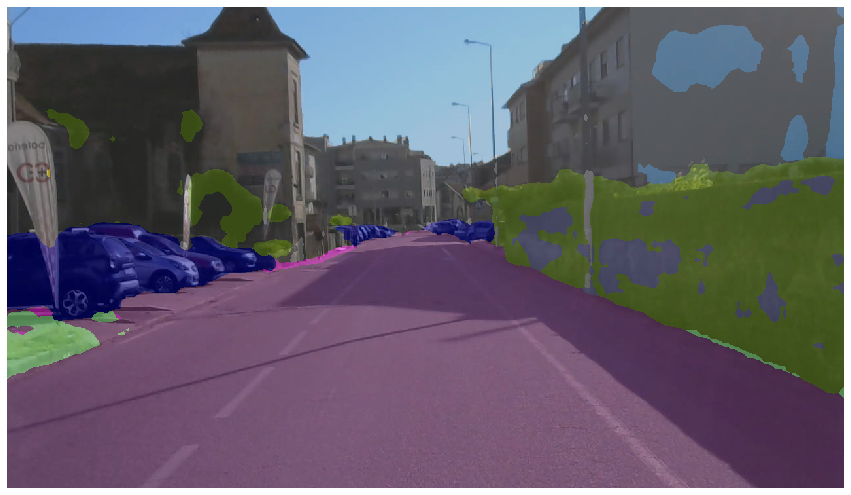

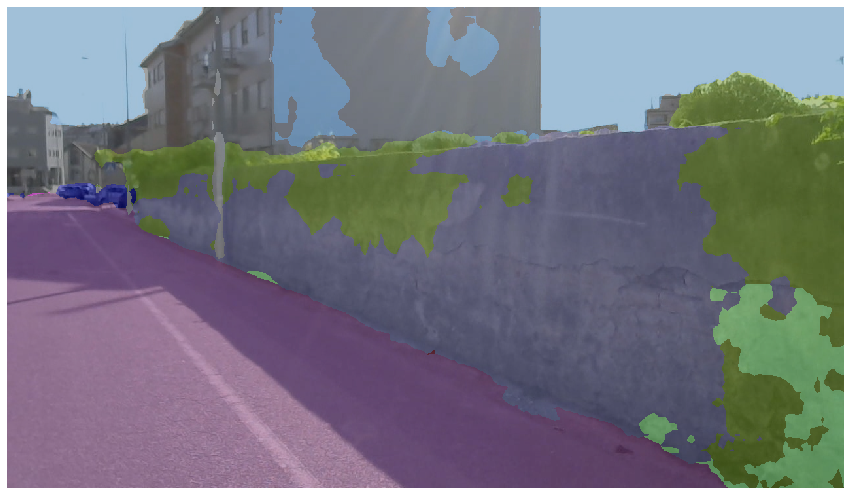

In [9]:
########Imagens para CALIBRAÇÃO##########
ID = 71
CAMADA = 19
#########################################

#ID = 114
#CAMADA = 41

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]

print(imgsD.shape)

tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])

xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])

with torch.no_grad():
    yD = model(xD.cuda(0)).cpu()
    yE = model(xE.cuda(0)).cpu()
    yM = model(xM.cuda(0)).cpu()
    
#with torch.no_grad():
#    yD = model(xD).cpu()
#    yE = model(xE).cpu()
#    yM = model(xM).cpu()
    
    
left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]

classesD = torch.argmax(yD, dim=1)
classesE = torch.argmax(yE, dim=1)
classesM = torch.argmax(yM, dim=1)

Segmentacao=1
if Segmentacao==1:
    outputD = 0.5 * (imgsD / 255.) + 0.5 * colormap(classesD)[..., :3]
    outputE = 0.5 * (imgsE / 255.) + 0.5 * colormap(classesE)[..., :3]
    outputM = 0.5 * (imgsM / 255.) + 0.5 * colormap(classesM)[..., :3]
else:
    outputD = classesD
    outputE = classesE
    outputM = classesM
    
    
fig, al = plt.subplots(figsize=(15, 15))
al.imshow((outputE[-1,:,:]))
al.set_axis_off()

fig, am = plt.subplots(figsize=(15, 15))
am.imshow((outputM[-1,:,:]))
am.set_axis_off()

fig, ar = plt.subplots(figsize=(15, 15))
ar.imshow((outputD[-1,:,:]))
ar.set_axis_off()
#plt.savefig('Seg-D-_0114_Camada 41.jpg', dpi=100)

## Panoramic image 

Chegou ate aqui
supostamente calculou tudo
Criei panorâmica só com a estrada
3.787684679031372


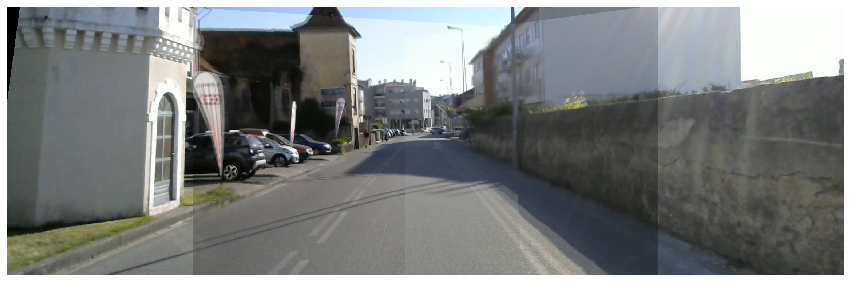

In [8]:
ID = 71
CAMADA = 19

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]
    
left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]
        
result_width=2300

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)

LI=torch.from_numpy(left_image.copy())
MI=torch.from_numpy(center_image.copy())
RI=torch.from_numpy(right_image.copy())
LI=LI[None, :, :]
LI=LI.permute(0,3, 1, 2)
MI=MI[None, :, :]
MI=MI.permute(0,3, 1, 2)
RI=RI[None, :, :]
RI=RI.permute(0,3, 1, 2)


start = time()
for i in range(1):
    result_width=2300
    if left_image is not None and center_image is not None and right_image is not None:

        #resultMaskFinal = stitcher.stitchNormal([torch.from_numpy(imgsE.copy().astype()),torch.from_numpy(imgsM.copy()), torch.from_numpy(imgsD.copy())],result_width,M_left_center,M_center_right)
        resultMaskFinal = stitcher.stitch([LI.float(),MI.float(),RI.float()],result_width,M_left_center,M_center_right)
        PanoramicImage=resultMaskFinal[-1,:,:,:].permute(1, 2,0)


        if resultMaskFinal is None:
            print("There was an error in the stitching procedure")
        else:
            print("Criei panorâmica só com a estrada")
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.imshow(PanoramicImage/ 255.)
            ax.set_axis_off()
            plt.savefig('Images_Presentation/PanoNormal.jpg', dpi=500)
    else:
        print("Falta as imagens!")


end = time()
record= end - start
print(record)

## Panoramic image Segmented

Chegou ate aqui
supostamente calculou tudo
Criei panorâmica só com a estrada
2.8313612937927246


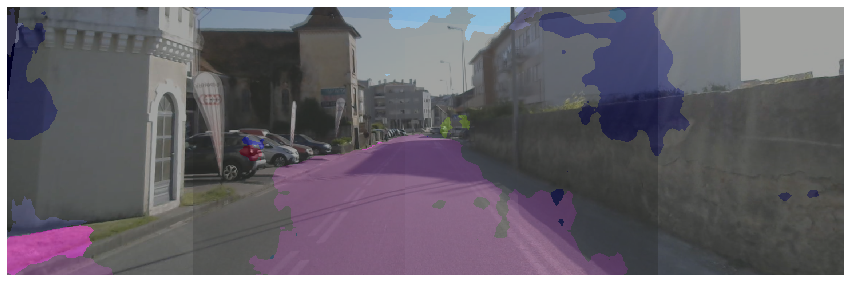

In [14]:
ID = 71
CAMADA = 19

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]
    
left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]
        
result_width=2300

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)

LI=torch.from_numpy(left_image.copy())
MI=torch.from_numpy(center_image.copy())
RI=torch.from_numpy(right_image.copy())
LI=LI[None, :, :]
LI=LI.permute(0,3, 1, 2)
MI=MI[None, :, :]
MI=MI.permute(0,3, 1, 2)
RI=RI[None, :, :]
RI=RI.permute(0,3, 1, 2)

start = time()
for i in range(1):
    result_width=2300
    if left_image is not None and center_image is not None and right_image is not None:

        #resultMaskFinal = stitcher.stitchNormal([torch.from_numpy(imgsE.copy().astype()),torch.from_numpy(imgsM.copy()), torch.from_numpy(imgsD.copy())],result_width,M_left_center,M_center_right)
        resultMaskFinal = stitcher.stitch([LI.float(),MI.float(),RI.float()],result_width,M_left_center,M_center_right)
        resultMaskFinal=resultMaskFinal[-1,:,:,:].permute(1, 2,0)

        resultMaskFinal = resultMaskFinal/ 255.
        resultMaskFinal = resultMaskFinal[None,:,:,:]  # BxCxHxW
        resultMaskFinal = resultMaskFinal.permute(0,3, 1, 2)

        with torch.no_grad():
            yD = model(resultMaskFinal.cuda(3)).cpu()
        resultMaskFinal = torch.argmax(yD, dim=1)

        if resultMaskFinal is None:
            print("There was an error in the stitching procedure")
        else:
            print("Criei panorâmica só com a estrada")
            PanSegmentada = 0.5 * (PanoramicImage / 255.) + 0.5 * colormap(resultMaskFinal[0])[None,:,:2300,:3]
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.imshow(PanSegmentada[-1])
            ax.set_axis_off()
            plt.savefig('Images_Presentation/PanoSegment.jpg', dpi=500)
            
    else:
        print("Falta as imagens!")


end = time()
record= end - start
print(record)

## Panoramic image Mask with Argmax

Chegou ate aqui
supostamente calculou tudo
Criei panorâmica só com a estrada
9.68208384513855


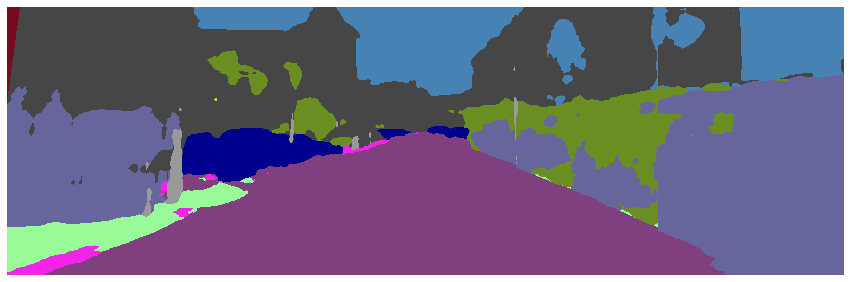

In [33]:
ID = 71
CAMADA = 19

import datetime
start_time = datetime.datetime.now()

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]

tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])


xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)

start = time()
for i in range(1):
    with torch.no_grad():
        yD = model(xD.cuda(3)).cpu()
        yE = model(xE.cuda(3)).cpu()
        yM = model(xM.cuda(3)).cpu()

    #with torch.no_grad():
    #    yD = model(xD).cpu()
    #    yE = model(xE).cpu()
    #    yM = model(xM).cpu()


    resultMask=torch.zeros([1,19,736,2300])

    if yE is not None and yM is not None and yD is not None:

        for i in range(19):
            data = yE[:,i:i+1,:,:]  # BxCxHxW
            data2 = yM[:,i:i+1,:,:]
            data3 = yD[:,i:i+1,:,:]
            # print("Calculei os inputs")

            resultMask[:,i,:,:] = stitcher.stitch([data.float(),data2.float(), data3.float()],result_width,M_left_center,M_center_right)
        # print(resultMask)
        A=torch.argmax(resultMask, dim=1)
        # print(resultMask.shape)
        if resultMask is None:
            print("There was an error in the stitching procedure")
        else:
            print("Criei panorâmica só com a estrada")
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.set_axis_off()
            ax.imshow(colormap(A[0]))
            fig.show()
            
    else:
        print("Falta as imagens!")

end = time()
record= end - start
print(record)

## Panoramic image Mask with images

Chegou ate aqui
supostamente calculou tudo
Criei panorâmica só com a estrada
1.194420337677002


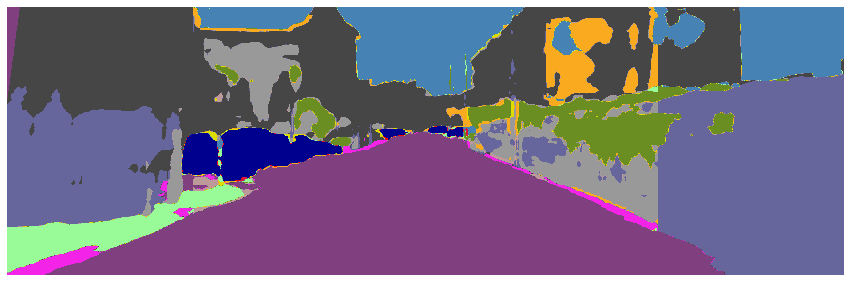

In [20]:
ID = 71
CAMADA = 19

import datetime
start_time = datetime.datetime.now()

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]


tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])


xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])


left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)

start = time()
for i in range(1):

    with torch.no_grad():
        yD = model(xD.cuda(3)).cpu()
        yE = model(xE.cuda(3)).cpu()
        yM = model(xM.cuda(3)).cpu()
    #with torch.no_grad():
    #    yD = model(xD).cpu()
    #    yE = model(xE).cpu()
    #    yM = model(xM).cpu()


    classesD = torch.argmax(yD, dim=1)
    classesE = torch.argmax(yE, dim=1)
    classesM = torch.argmax(yM, dim=1)
    

    if classesE is not None and classesM is not None and classesD is not None:


        #data = (classesE[0]==0)
        #data2 = (classesM[0]==0)
        #data3 = (classesD[0]==0)
        #data = data[None,None,:,:]
        #data2 = data2[None,None,:,:]
        #data3 = data3[None,None,:,:]
        
        data = (classesE[:])
        data2 = (classesM[:])
        data3 = (classesD[:])
        
        data = data[None,:,:]
        data2 = data2[None,:,:]
        data3 = data3[None,:,:]

        

        resultMask = stitcher.stitch([data.float(),data2.float(), data3.float()],result_width,M_left_center,M_center_right)
        #resultMask = resultMask[-1,-1]
        #resultMask[resultMask>0] = 1

        if resultMask is None:
            print("There was an error in the stitching procedure")
        else:
            print("Criei panorâmica só com a estrada")
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.set_axis_off()
            ax.imshow(colormap(np.rint(resultMask[-1,-1,:,:].numpy()).astype(int)))
            fig.show()
            
    else:
        print("Falta as imagens!")
    
end = time()
record= end - start
print(record)

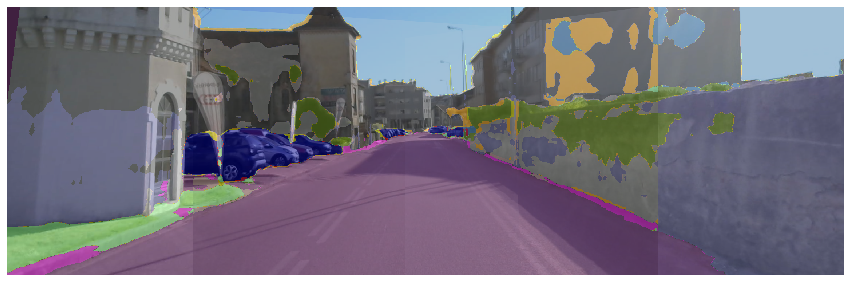

In [22]:
Pan = 0.5 * (PanoramicImage / 255.) + 0.5 * colormap(np.rint(resultMask[-1,-1,:,:].numpy()).astype(int))[:,:,:3]
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_axis_off()
ax.imshow(Pan)
plt.savefig('Images_Presentation/PanoSingles.jpg', dpi=500)

## Panoramic image Mask with Polygon

Chegou ate aqui
supostamente calculou tudo
Polygon with Lines
2.3110427856445312


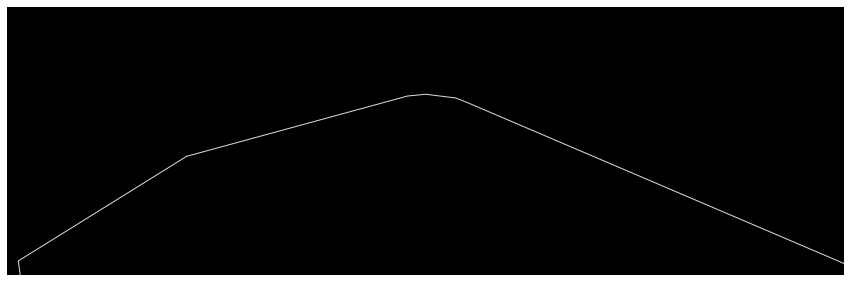

In [28]:
ID = 71
CAMADA = 19

import datetime
start_time = datetime.datetime.now()

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]


tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])


xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])


left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)


start = time()

for i in range(1):
    with torch.no_grad():
        yD = model(xD.cuda(3)).cpu()
        yE = model(xE.cuda(3)).cpu()
        yM = model(xM.cuda(3)).cpu()
    #with torch.no_grad():
    #    yD = model(xD).cpu()
    #    yE = model(xE).cpu()
    #    yM = model(xM).cpu()

    classesD = torch.argmax(yD, dim=1)
    classesE = torch.argmax(yE, dim=1)
    classesM = torch.argmax(yM, dim=1)

    if classesE is not None and classesM is not None and classesD is not None:

        hullMode = True

        pointsD = polygonGenerator(classesD[0]==0,hullMode)
        pointsM = polygonGenerator(classesM[0]==0,hullMode)
        pointsE = polygonGenerator(classesE[0]==0,hullMode)

        teste = polygonStitcher([pointsE,pointsM,pointsD],736,1280,M_left_center,M_center_right,2300,hullMode,True)


    else:
        print("Falta as imagens!")
    
end = time()
record= end - start
print(record)

## Panoramic image Mask with Points

Chegou ate aqui
supostamente calculou tudo
Road Points
11.944122552871704


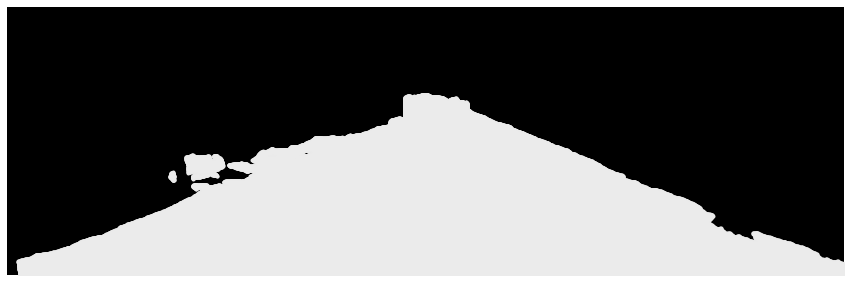

In [27]:
ID = 71
CAMADA = 19

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])

imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]


tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])


xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])

left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)


start = time()

for i in range(1):
    with torch.no_grad():
        yD = model(xD.cuda(3)).cpu()
        yE = model(xE.cuda(3)).cpu()
        yM = model(xM.cuda(3)).cpu()
    #with torch.no_grad():
    #    yD = model(xD).cpu()
    #    yE = model(xE).cpu()
    #    yM = model(xM).cpu()

    classesD = torch.argmax(yD, dim=1)
    classesE = torch.argmax(yE, dim=1)
    classesM = torch.argmax(yM, dim=1)

    if classesE is not None and classesM is not None and classesD is not None:

        hullMode = False

        pointsD = polygonGenerator(classesD[0]==0,hullMode)
        pointsM = polygonGenerator(classesM[0]==0,hullMode)
        pointsE = polygonGenerator(classesE[0]==0,hullMode)

        teste = polygonStitcher([pointsE,pointsM,pointsD],736,1280,M_left_center,M_center_right,2300,hullMode,False)


    else:
        print("Falta as imagens!")
    
    
end = time()
record= end - start
print(record)

In [19]:
print
np.where((teste2)==2532.0)

(array([997277]), array([0]))

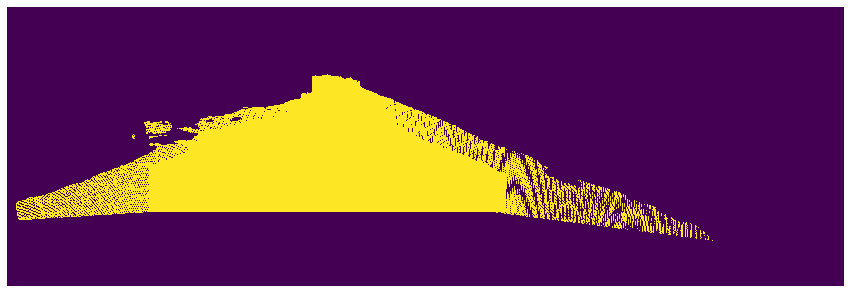

In [44]:

teste2 = np.rint(teste)
arrayvazio= np.zeros((1000,3000))
for i in range(len(teste2)):
    if ((int(teste2[i,1])>= 0 & (int(teste2[i,1]))<= 736) | (int(teste2[i,0])<= 2300 & int(teste2[i,0]))>= 0):
        arrayvazio[736-int(teste2[i,1]),int(teste2[i,0])]= 255
    
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(arrayvazio)
ax.set_axis_off()

## Panoramic image segmented

**Run the Panoramic image & Panoramic image Mask with Argmax modules before running this one!**

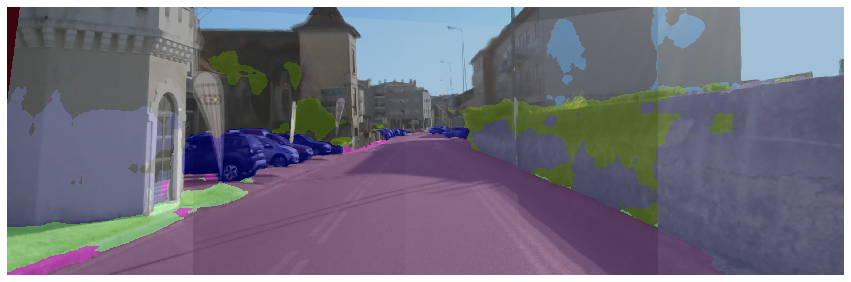

In [36]:
PanSegmentada = 0.5 * (resultMaskFinal.permute(0,2, 3, 1)[-1]/ 255.) + 0.5 * colormap(A[0])[..., :3]
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(PanSegmentada)
ax.set_axis_off()
plt.savefig('Images_Presentation/PanoArgmax.jpg', dpi=500)

(1, 736, 2304, 3)


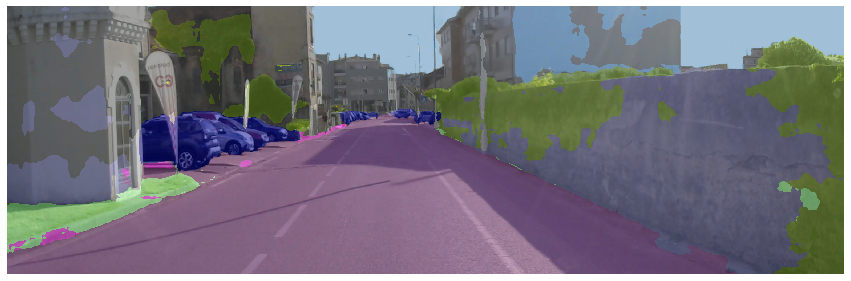

In [12]:
imagepanormica = glob(f'pano2_fused.jpg')


imgs = np.stack([ cv2.imread(f) for f in imagepanormica ])


imgs = np.stack([ cv2.resize(img, (2304,736)) for img in imgs ])


imgs = imgs[..., ::-1]


imgs = imgs[:, :, ...]

print(imgs.shape)

tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])

x = torch.stack([ tfms(image=image)['image'] for image in imgs ])


with torch.no_grad():
    y = model(x.cuda(0)).cpu()

    
#with torch.no_grad():
#    yD = model(xD).cpu()
#    yE = model(xE).cpu()
#    yM = model(xM).cpu()
    
image = imgs[0]

classes = torch.argmax(y, dim=1)


Segmentacao=1
if Segmentacao==1:
    output = 0.5 * (imgs / 255.) + 0.5 * colormap(classes)[..., :3]
else:
    output = classes

    
fig, al = plt.subplots(figsize=(15, 15))
al.imshow((output[-1,:,:]))
al.set_axis_off()

